# Capstone Project - Food Classifier

## Overview

The aim of this Capstone Project is to use deep learning to classify images of food. The notebook will include all implementation stages of the project including, data processing, training and building the model and finally an analysis of the results. 

### How do I run this project?

Please refer to the README at https://github.com/winghymliu/deeplearning-foodclassifier/blob/master/README.md


## Data Processing

The project uses the UECFOOD256 from an academic insitute in Japan, the dataset contains 31,651 images in 256 folders with each folder being a particular category of the food.

In [1]:
from os import listdir
import os.path
import pandas as pd
from sklearn.datasets import load_files    
from sklearn.model_selection import train_test_split
import numpy as np
from shutil import copyfile
from keras.utils import np_utils

raw_dataset = r'UECFOOD256'
categories = r'labels.txt' 
images_folder = r'food-images'
train_folder = os.path.join(images_folder, 'train')
valid_folder = os.path.join(images_folder, 'valid')
test_folder = os.path.join(images_folder, 'test')

def create_folder(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
        
create_folder(images_folder)
create_folder(train_folder)
create_folder(valid_folder)
create_folder(test_folder)

labels = pd.read_csv(categories, sep=",", header=0)
num_food_labels = len(labels)

def get_label_from_raw(raw_label, labels):
    return labels.iloc[int(raw_label)-1]["name"]

Using TensorFlow backend.


### Cross validation

Currently the images are all grouped together within their labeled folders and they need to be seperated into the training, validation and testing sets for each label. First the names of the files are loaded into a collection, then train_test_split is used to obtain the training and testing set. The method is called again to further split the training data into training and validation sets.

A three folders are created: train, valid, test which each contain a subfolder with the correct label and the images from our cross validation split earlier. The methods are defined here:

In [2]:
# Function to confirm the number of files per label
def get_total_images_per_label(path):
    total = 0
    for item in listdir(path):
        image_folder = os.path.join(path, item)
        if os.path.isdir(image_folder):        
            images = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]
            print('Folder ' + item + ' has ' + str(len(images)) + ' images')
            total = total + len(images)
    print('total files ' + str(total))

# Cross validation
# Split the data once to obtain the test set and again to get the training and validation sets
def train_validate_test_split(path, raw_label, labels):
    label = get_label_from_raw(raw_label, labels)
    image_folder = os.path.join(path, raw_label)
    files = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]  

    X = np.vstack(files)
    y = np.vstack([label] * len(files))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
        
    return X_train, X_val, X_test, y_train,  y_val, y_test

# In order for sklearn load_files to work correctly, the subdirectories have to be named after the labels
def copy_images_to_folder(src_folder, set_folder, food_label, images):
    target_folder = os.path.join(set_folder, food_label)
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)
    for image in images:        
        src = os.path.join(src_folder, image[0])
        dst = os.path.join(target_folder, image[0])
        copyfile(src, dst)        
        
# You have to pad the label which is a number with 0s at the front
# otherwise the labels will be in an incorrect order
def pad_raw_label(raw_label):
    return raw_label.zfill(3)
         
def split_and_transfer_raw_images(raw_dataset, labels):    
    raw_labels = [int(folder) for folder in listdir(raw_dataset) if os.path.isdir(os.path.join(raw_dataset, folder))]
    sorted_labels = sorted(raw_labels)
    for raw_label in raw_labels:
        raw_label = str(raw_label)
        X_train, X_val, X_test, y_train,  y_val, y_test = train_validate_test_split(raw_dataset, raw_label, labels) 
        food_label = pad_raw_label(raw_label) + '.' + get_label_from_raw(raw_label, labels)
        src_folder = os.path.join(raw_dataset, raw_label)
        copy_images_to_folder(src_folder, train_folder, food_label, X_train)
        copy_images_to_folder(src_folder, valid_folder, food_label, X_val)
        copy_images_to_folder(src_folder, test_folder, food_label, X_test)        

The cross validation split is performed here:

In [3]:
split_and_transfer_raw_images(raw_dataset, labels)

The data is now loaded:

In [4]:
%%time
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), len(labels))
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)
valid_files, valid_targets = load_dataset(valid_folder)
test_files, test_targets = load_dataset(test_folder)

# print statistics about the dataset
print('There are %d total food categories.' % num_food_labels)
print('There are %s total food images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training food images.' % len(train_files))
print('There are %d validation food images.' % len(valid_files))
print('There are %d test food images.'% len(test_files))

There are 256 total food categories.
There are 20140 total food images.

There are 14371 training food images.
There are 3675 validation food images.
There are 2094 test food images.
Wall time: 3.01 s


### Image Resize

As we construct tensors from the images, they need to be resized order to standardize the input dimensions for the convolutional neural network. 

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

channels = 3

def path_to_tensor(img_path, pixel_size):
    img = image.load_img(img_path, target_size=(pixel_size, pixel_size))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, pixel_size):
    list_of_tensors = [path_to_tensor(img_path, pixel_size) for img_path in tqdm(img_paths) if img_path.endswith('jpg')]
#    print([img_path for img_path in tqdm(img_paths) if img_path.endswith('jpg')])
    return np.vstack(list_of_tensors)

Loading the images and rescaling them

In [6]:
%%time
             
# pre-process the data for Keras
pixel_size = 64
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:12<00:00, 252.66it/s]


Wall time: 2min 9s


After creating the tensors we can view how they've been resized:

In [6]:
from matplotlib import pyplot

def display_samples(tensors):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(tensors[i], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()    

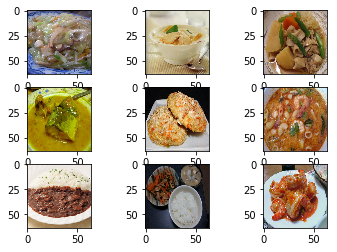

In [11]:
display_samples(train_tensors)

### Training the model and calculating the top 1 and top 5 accuracies

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  


# for debugging
def print_get_top5(predictions):
    print(predictions[0])
    ind = np.argsort(predictions[0])[-5:]
    print(ind)
    print(predictions[0][ind]) #values
    return ind

# Returns the indicies of the top 5 results from a prediction
def get_top5(predictions):    
    ind = np.argsort(predictions[0])[-5:]    
    return ind

# Calculates if the top 5 predictions matches the label
def calculate_top5_accuracy(model, test_tensors, test_targets):
    food_predictions = [get_top5(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
    flattened_targets = np.argmax(test_targets, axis=1)
        
    top5_results = np.array([val in food_predictions[idx] for idx, val in enumerate(flattened_targets)])
    
    test_accuracy = 100*np.sum(top5_results)/len(food_predictions)
    print('Top 5 test accuracy: %.4f%%' % test_accuracy)
    return test_accuracy
    
# Calculates if the top prediction matches the label
def calculate_accuracy(model, test_tensors, test_targets):    
    # makes a prediction on each tensor then gets the index of the label with the highest value
    food_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]    
    # report top 1 test accuracy
    # for each test target it gets the index of the label (which has the value 1 whilst the others have value 0)
    # the results are then flattened into a single array (hence the axis 1)
    test_accuracy = 100*np.sum(np.array(food_predictions)==np.argmax(test_targets, axis=1))/len(food_predictions)
    print('Top 1 test accuracy: %.4f%%' % test_accuracy)
    return test_accuracy

# Prerequiste: You must create the model exactly as expected before hand
# This will load the weights for the model and calculate the top 1 and top 5 accuracy rates on the test data
def run_tests_only(model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets, optimizer = 'rmsprop', 
                    prefix='basic'):
    hdf5_file = hdf5_name(pixel_size, num_conv_layers, num_pool_layers, prefix)
    print('Loading weights from ' + hdf5_file)
    model.load_weights('saved_weights/' + hdf5_file)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    calculate_accuracy(model, test_tensors, test_targets)
    calculate_top5_accuracy(model, test_tensors, test_targets)    

def print_model_summary(pixel_size, channels, num_conv_layers, num_pool_layers):
    print('Pixel size {}, channels {}, number of conv layers {}, number of pool layers {}'
          .format(pixel_size, channels, num_conv_layers, num_pool_layers))
    
def hdf5_name(pixel_size, num_conv_layers, num_pool_layers, prefix):
    return '{}.pixel.{}.conv.{}.pool.{}.hdf5'.format(prefix, pixel_size, num_conv_layers, num_pool_layers)

# Compiles the model, trains it and saves the best weights after each epoch
# Then calculates the accuracy rates
def compile_run_test(model, pixel_size, num_conv_layers, num_pool_layers, 
                    train_tensors, train_targets,
                    valid_tensors, valid_targets,
                    epochs = 5,
                    batch_size = 20,
                    optimizer = 'rmsprop',
                    prefix='basic'):
    
    # print the model summary
    model.summary()
    print_model_summary(pixel_size, channels, num_conv_layers, num_pool_layers)
    
    # create a checkpoint for recovery
    hdf5_file = hdf5_name(pixel_size, num_conv_layers, num_pool_layers, prefix)
    checkpointer = ModelCheckpoint(filepath='saved_weights/' + hdf5_file, 
                               verbose=1, save_best_only=True)
    print('Checkpoint at {}'.format(hdf5_file))
    
    # compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=2)
    
    model.load_weights('saved_weights/' + hdf5_file)
    calculate_accuracy(model, test_tensors, test_targets)
    calculate_top5_accuracy(model, test_tensors, test_targets)        
    
def compile_run_test_with_datagen_train_only(model, pixel_size, num_conv_layers, num_pool_layers, 
                    train_tensors, train_targets,
                    valid_tensors, valid_targets,
                    datagen,
                    epochs = 5,
                    batch_size = 20,
                    optimizer = 'rmsprop',
                    prefix = 'nozca'                      
                    ):
    
    # print the model summary
    model.summary()
    print_model_summary(pixel_size, channels, num_conv_layers, num_pool_layers)
    
    # create a checkpoint for recovery
    hdf5_file = hdf5_name(pixel_size, num_conv_layers, num_pool_layers, prefix)
    checkpointer = ModelCheckpoint(filepath='saved_weights/' + hdf5_file, 
                               verbose=1, save_best_only=True)
    print('Checkpoint at {}'.format(hdf5_file))
    
    # compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=32),
                        validation_data=(valid_tensors, valid_targets),
                        steps_per_epoch=len(train_tensors) / 32, 
                        epochs=epochs, callbacks=[checkpointer], verbose=2)   
    
    model.load_weights('saved_weights/' + hdf5_file)
    calculate_accuracy(model, test_tensors, test_targets)     
    calculate_top5_accuracy(model, test_tensors, test_targets)    

def compile_run_test_with_datagen(model, pixel_size, num_conv_layers, num_pool_layers, 
                    train_tensors, train_targets,
                    valid_tensors, valid_targets,
                    train_datagen,
                    valid_datagen,              
                    epochs = 5,
                    batch_size = 20,
                    optimizer = 'rmsprop',
                    prefix = 'nozca'                      
                    ):
           
    # print the model summary
    model.summary()
    print_model_summary(pixel_size, channels, num_conv_layers, num_pool_layers)
    
    # create a checkpoint for recovery
    hdf5_file = hdf5_name(pixel_size, num_conv_layers, num_pool_layers, prefix)
    checkpointer = ModelCheckpoint(filepath='saved_weights/' + hdf5_file, 
                               verbose=1, save_best_only=True)
    print('Checkpoint at {}'.format(hdf5_file))
    
    # compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=32),
                        validation_data=valid_datagen.flow(valid_tensors, valid_targets, batch_size=32),
                        validation_steps=len(valid_tensors)/32,
                        steps_per_epoch=len(train_tensors) / 32, 
                        epochs=epochs, callbacks=[checkpointer], verbose=2)   
    
    model.load_weights('saved_weights/' + hdf5_file)
    calculate_accuracy(model, test_tensors, test_targets)     
    calculate_top5_accuracy(model, test_tensors, test_targets)

## Basic Classifiers without image augmentations

### Bench mark model

The first model of our experiments will have one convolutional and one pooling layer and will form the benchmark for our other tests. 

In [10]:
basic_model = Sequential()
num_conv_layers = 1
num_pool_layers = 1
basic_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(GlobalAveragePooling2D())
basic_model.add(Dense(num_food_labels, activation='softmax'))

In [11]:
run_tests_only(basic_model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets)

Loading weights from basic.pixel.64.conv.1.pool.1.hdf5
Top1 test accuracy: 2.6050%
Top5 test accuracy: 8.1214%


In [14]:
%%time
# create a basic result without augmentation
compile_run_test(   model=basic_model, 
                    pixel_size=pixel_size, num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4352      
Total params: 4,560.0
Trainable params: 4,560.0
Non-trainable params: 0.0
_________________________________________________________________
Pixel size 64, channels 3, number of conv layers 1, number of pool layers 1
Checkpoint at basic.pixel.64.conv.1.pool.1.hdf5
Train on 22402 samples, validate on 5730 samples
Epoch 1/5
22402/22402 [==============================] - 35s - loss: 5.5094 - acc: 0.0227 - v

### Basic classifier with more layers

In [12]:
basic_model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
basic_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(GlobalAveragePooling2D())
basic_model.add(Dense(num_food_labels, activation='softmax'))

In [16]:
%%time
# create a basic result without augmentation but more layers
compile_run_test(   model=basic_model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

In [13]:
run_tests_only(basic_model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets)

Loading weights from basic.pixel.64.conv.3.pool.3.hdf5
Top1 test accuracy: 5.0260%
Top5 test accuracy: 16.7944%


### Basic classifier with more pixels

In [14]:
pixel_size = 128
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:13<00:00, 239.44it/s]


In [16]:
basic_model_128 = Sequential()
num_conv_layers = 3
num_pool_layers = 3
basic_model_128.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model_128.add(MaxPooling2D(pool_size=(2,2)))
basic_model_128.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_128.add(MaxPooling2D(pool_size=(2,2)))
basic_model_128.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_128.add(MaxPooling2D(pool_size=(2,2)))
basic_model_128.add(GlobalAveragePooling2D())
basic_model_128.add(Dense(num_food_labels, activation='softmax'))

In [19]:
%%time
# create a basic result without augmentation but with 128 pixels
compile_run_test(   model=basic_model_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
__________

In [17]:
run_tests_only(basic_model_128, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets)

Loading weights from basic.pixel.128.conv.3.pool.3.hdf5
Top1 test accuracy: 4.7502%
Top5 test accuracy: 14.8330%


### Basic classifier with the maximum pixel size possible

The maximum pixel size our hardware can handle is 256, more RAM is needed to increase the number of pixels.

In [20]:
%%time
pixel_size = 256
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:22<00:00, 144.44it/s]


CPU times: user 2min 50s, sys: 30.9 s, total: 3min 21s
Wall time: 3min 26s


In [21]:
basic_model_256 = Sequential()
num_conv_layers = 3
num_pool_layers = 3
basic_model_256.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
basic_model_256.add(MaxPooling2D(pool_size=(2,2)))
basic_model_256.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_256.add(MaxPooling2D(pool_size=(2,2)))
basic_model_256.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
basic_model_256.add(MaxPooling2D(pool_size=(2,2)))
basic_model_256.add(GlobalAveragePooling2D())
basic_model_256.add(Dense(num_food_labels, activation='softmax'))

In [22]:
%%time
# create a basic result without augmentation but with 256 pixels
compile_run_test(   model=basic_model_256, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
__________

In [ ]:
run_tests_only(basic_model_256, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets)

### Image Augmentation

After rescaling the images, we should perform image augmentation, this involves a few processes:
* Standardization
* Whitening (ZCA)
* Random Rotations
* Random Shifts
* Random Flips

In [8]:
from keras.preprocessing.image import ImageDataGenerator 
from keras import backend as K

def display_first_batch(X, y, datagen, batchsize=9):
    for X_batch, y_batch in datagen.flow(X, y, batch_size=batchsize):
        display_samples(X_batch)
        break                

In [14]:
%%time
pixel_size = 96
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:15<00:00, 208.14it/s]


CPU times: user 2min 32s, sys: 2.49 s, total: 2min 35s
Wall time: 2min 34s


### Normalization Example

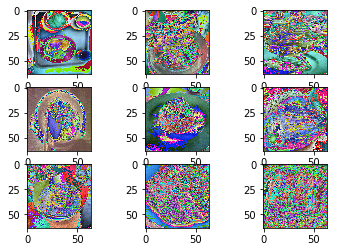

CPU times: user 8.52 s, sys: 1.16 s, total: 9.68 s
Wall time: 8.69 s


In [12]:
%%time
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### ZCA Whitening example

In [ ]:
%%time
# warning doesn't run on laptop
datagen = ImageDataGenerator(zca_whitening=True)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Random Rotation example

In [ ]:
%%time
datagen = ImageDataGenerator(rotation_range=90)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Random Shifts Example

In [ ]:
%%time
shift = 0.2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Random Flips Example

In [ ]:
%%time
shift = 0.2
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
datagen.fit(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

### Findings from image augmentation

The ZCA whitening process was suprisingly memory and computation intensive with an exponential cost as the resolution of the images were increased. 

### Image augmentation with normalization

The following experiments were run with a data generator that did the following:
* Normalization
* Random Fips
* Random Rotations
* Random Shifts

Due to the limitations on hardware, the maximum pixels size that could be used was 128.

In [9]:
def datagen_no_zca(train_tensors):
    datagen = ImageDataGenerator(
        featurewise_center=True, featurewise_std_normalization=True,
        zca_whitening=False,
        rotation_range=90,
        width_shift_range=0.2, height_shift_range=0.2,
        horizontal_flip=True, vertical_flip=True)

    datagen.fit(train_tensors)
    return datagen

In [10]:
%%time
pixel_size = 128
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 2094/2094 [00:10<00:00, 202.55it/s]


Wall time: 1min 51s


#### Data Generator with normalization

In [16]:
%%time
train_datagen = datagen_no_zca(train_tensors)
valid_datagen = datagen_no_zca(train_tensors)

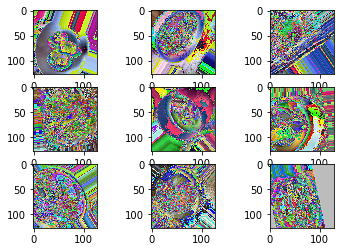

Wall time: 672 ms


In [17]:
%%time
display_first_batch(train_tensors, train_targets, train_datagen)

#### Data Generator with normalization: 3 Convolutional layers, 3 Pooling layers

In [18]:
no_zca_model_128 = Sequential()
num_conv_layers = 3
num_pool_layers = 3
no_zca_model_128.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(GlobalAveragePooling2D())
no_zca_model_128.add(Dense(num_food_labels, activation='softmax'))

In [21]:
%%time
# creates a simple model with augmentation minus zca
compile_run_test_with_datagen(   model=no_zca_model_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    train_datagen=train_datagen,
                    valid_datagen=valid_datagen,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

#### Data Generator with normalization: 4 Convolutional layers, 4 Pooling layers

In [22]:
no_zca_model_128 = Sequential()
num_conv_layers = 4
num_pool_layers = 4
no_zca_model_128.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128.add(GlobalAveragePooling2D())
no_zca_model_128.add(Dense(num_food_labels, activation='softmax'))

In [23]:
%%time
compile_run_test_with_datagen(model=no_zca_model_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    train_datagen=train_datagen,
                    valid_datagen=valid_datagen,
                    epochs = 5,
                    batch_size = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       32896     
__________

#### Data Generator with normalization:  4 Convolutional layers, 4 Pooling layers, 64 nodes

In [31]:
no_zca_model_128_nodes_64 = Sequential()
num_conv_layers = 4
num_pool_layers = 4
no_zca_model_128_nodes_64.add(Conv2D(64, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
no_zca_model_128_nodes_64.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_64.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128_nodes_64.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_64.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128_nodes_64.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_64.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128_nodes_64.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_64.add(GlobalAveragePooling2D())
no_zca_model_128_nodes_64.add(Dense(num_food_labels, activation='softmax'))

In [32]:
%%time
compile_run_test_with_datagen(model=no_zca_model_128_nodes_64, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    train_datagen=train_datagen,
                    valid_datagen=valid_datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'nozca.64.nodes')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        16448     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        16448     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        16448     
__________

#### Data Generator with normalization: 4 Convolutional layers, 4 Pooling layers, 128 nodes

In [33]:
no_zca_model_128_nodes_128 = Sequential()
num_conv_layers = 4
num_pool_layers = 4
no_zca_model_128_nodes_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
no_zca_model_128_nodes_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128_nodes_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128_nodes_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_128.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
no_zca_model_128_nodes_128.add(MaxPooling2D(pool_size=(2,2)))
no_zca_model_128_nodes_128.add(GlobalAveragePooling2D())
no_zca_model_128_nodes_128.add(Dense(num_food_labels, activation='softmax'))

In [18]:
no_zca_model_128_nodes_128.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 128)     1664      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       65664     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       65664     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       65664     
__________

In [34]:
%%time
compile_run_test_with_datagen(model=no_zca_model_128_nodes_128, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    train_datagen=train_datagen,
                    valid_datagen=valid_datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'nozca.128.nodes')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 128, 128, 128)     1664      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 128)       65664     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)       65664     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 128)       65664     
__________

#### Data Generator with normalization:  4 Convolutional layers, 4 Pooling layers, ascending nodes

In [35]:
nozca_model = Sequential()
num_conv_layers = 4
num_pool_layers = 4
nozca_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
nozca_model.add(MaxPooling2D(pool_size=(2,2)))
nozca_model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
nozca_model.add(MaxPooling2D(pool_size=(2,2)))
nozca_model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
nozca_model.add(MaxPooling2D(pool_size=(2,2)))
nozca_model.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
nozca_model.add(MaxPooling2D(pool_size=(2,2)))
nozca_model.add(GlobalAveragePooling2D())
nozca_model.add(Dense(num_food_labels, activation='softmax'))

In [36]:
%%time
compile_run_test_with_datagen(model=nozca_model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    train_datagen=train_datagen,
                    valid_datagen=valid_datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'nozca.multi.nodes')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 128)       32896     
__________

#### Data Generator with normalization: 3 Convolutional layers, 3 Pooling layers, ascending nodes with dropouts

In [37]:
nozca_model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
nozca_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
nozca_model.add(Dropout(0.5))
nozca_model.add(MaxPooling2D(pool_size=(2,2)))
nozca_model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
nozca_model.add(Dropout(0.5))
nozca_model.add(MaxPooling2D(pool_size=(2,2)))
nozca_model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
nozca_model.add(Dropout(0.5))
nozca_model.add(MaxPooling2D(pool_size=(2,2)))
nozca_model.add(GlobalAveragePooling2D())
nozca_model.add(Dense(num_food_labels, activation='softmax'))

In [38]:
%%time
compile_run_test_with_datagen(model=nozca_model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    train_datagen=train_datagen,
                    valid_datagen=valid_datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'nozca.multi.nodes.dropout')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        8256      
__________

### Image Augmentation without standardization

I noticed my data generator with standardization produced surprisingly poor results and did not improve on the benchmark that we had initially for the project. I've decided to set the featurewise_center and featurewise_std_normalization to false for the DataImageGenerator. Now the augmentation process only does the following:

* Random flips
* Random rotations
* Random shifts

In [18]:
def datagen_nozca_nostd(train_tensors):
    datagen = ImageDataGenerator(
        featurewise_center=False, featurewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        width_shift_range=0.2, height_shift_range=0.2,
        horizontal_flip=True, vertical_flip=True)

    datagen.fit(train_tensors)
    return datagen

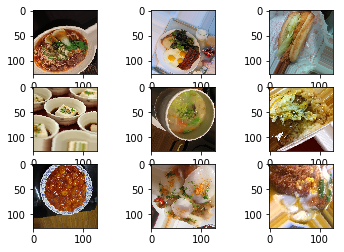

CPU times: user 2.11 s, sys: 1.64 s, total: 3.75 s
Wall time: 3.02 s


In [28]:
%%time
datagen = datagen_nozca_nostd(train_tensors)
display_first_batch(train_tensors, train_targets, datagen)

#### Basic augmentation: 3 Layer model

In [19]:
model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_food_labels, activation='softmax'))

In [15]:
%%time
compile_run_test_with_datagen_train_only(model=model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'nozca.nostd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [20]:
run_tests_only(model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets, prefix = 'nozca.nostd')

Loading weights from nozca.nostd.pixel.128.conv.3.pool.3.hdf5
Top1 test accuracy: 3.8921%
Top5 test accuracy: 13.4845%


#### Basic augmentation:  3 Layers with dropouts

In [21]:
model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_food_labels, activation='softmax'))

In [17]:
%%time
compile_run_test_with_datagen_train_only(model=model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'nozca.nostd.dropouts')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        8256      
__________

In [22]:
run_tests_only(model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets, prefix = 'nozca.nostd.dropouts')

Loading weights from nozca.nostd.dropouts.pixel.128.conv.3.pool.3.hdf5
Top1 test accuracy: 3.4631%
Top5 test accuracy: 11.7683%


#### Basic augmentation:  3 layers with dropout more epochs

In [23]:
model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_food_labels, activation='softmax'))

In [20]:
%%time
compile_run_test_with_datagen_train_only(model=model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 10,
                    batch_size = 20,
                    prefix = 'nozca.nostd.dropouts.10.epochs')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        8256      
__________

In [24]:
run_tests_only(model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets, prefix = 'nozca.nostd.dropouts.10.epochs')

Loading weights from nozca.nostd.dropouts.10.epochs.pixel.128.conv.3.pool.3.hdf5
Top1 test accuracy: 5.3325%
Top5 test accuracy: 18.7251%


#### Basic augmentation: 4 layers epoch 10 with dropouts

In [25]:
model = Sequential()
num_conv_layers = 4
num_pool_layers = 4
model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_food_labels, activation='softmax'))

In [22]:
%%time
compile_run_test_with_datagen_train_only(model=model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 10,
                    batch_size = 20,
                    prefix = 'nozca.nostd.dropouts.10.epochs')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [26]:
run_tests_only(model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets, prefix = 'nozca.nostd.dropouts.10.epochs')

Loading weights from nozca.nostd.dropouts.10.epochs.pixel.128.conv.4.pool.4.hdf5
Top1 test accuracy: 6.0987%
Top5 test accuracy: 20.6252%


#### Basic augmentation:  4 layers, epoch 10, dropouts and more nodes

In [27]:
model = Sequential()
num_conv_layers = 4
num_pool_layers = 4
model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_food_labels, activation='softmax'))

In [24]:
%%time
compile_run_test_with_datagen_train_only(model=model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 10,
                    batch_size = 20,
                    prefix = 'nozca.nostd.morenodes.dropouts.10.epochs')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      416       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        16448     
__________

In [28]:
run_tests_only(model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets, prefix = 'nozca.nostd.morenodes.dropouts.10.epochs')

Loading weights from nozca.nostd.morenodes.dropouts.10.epochs.pixel.128.conv.4.pool.4.hdf5
Top1 test accuracy: 9.1940%
Top5 test accuracy: 25.6206%


#### Basic augmentation:  4 layers, epoch 10, higher dropouts and more nodes

In [29]:
model = Sequential()
num_conv_layers = 4
num_pool_layers = 4
model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (2,2), strides=(1,1), padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_food_labels, activation='softmax'))

In [ ]:
%%time
compile_run_test_with_datagen_train_only(model=model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 10,
                    batch_size = 20,
                    prefix = 'nozca.nostd.morenodes.dropoutsv2.10.epochs')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      416       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        16448     
__________

In [ ]:
run_tests_only(model, pixel_size, num_conv_layers, num_pool_layers, test_tensors, test_targets, prefix = 'nozca.nostd.morenodes.dropoutsv2.10.epochs')

### Image augmentation with ZCA

The final experiment was an attempt at ZCA whitening which should highlight features within the images. However, I quickly discovered that it was an extremely expensive process that increases exponentially with pixel sizes. Even running ZCA on images with 64 pixels will easily consume over 32GB of RAM. Hence, I've only ran it and recorded the results once. If we extend the project further one day, perhaps we could obtain better hardware to run it.

In [10]:
%%time
pixel_size = 32
zca_train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
zca_valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
zca_test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

100%|██████████| 3263/3263 [00:15<00:00, 204.45it/s]


CPU times: user 2min 34s, sys: 2.09 s, total: 2min 36s
Wall time: 2min 35s


In [11]:
%%time
shift = 0.2
def datagen_zca(train_tensors):
    datagen = ImageDataGenerator(
        featurewise_center=False, featurewise_std_normalization=False,
        zca_whitening=True,
        rotation_range=90,
        width_shift_range=0.2, height_shift_range=0.2,
        horizontal_flip=True, vertical_flip=True)

    datagen.fit(train_tensors)
    return datagen

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


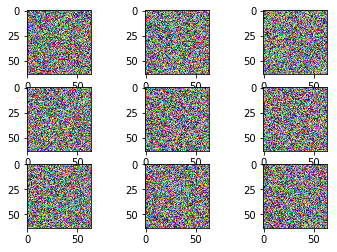

CPU times: user 36min 25s, sys: 1min 35s, total: 38min
Wall time: 9min 45s


In [12]:
%%time
train_datagen = datagen_zca(train_tensors)
valid_datagen = datagen_zca(valid_tensors)
display_first_batch(train_tensors, train_targets, datagen)

#### ZCA 3 Layers

In [13]:
zca_model = Sequential()
num_conv_layers = 3
num_pool_layers = 3
zca_model.add(Conv2D(16, (2,2), strides=(1,1), padding='same', input_shape=(pixel_size, pixel_size, channels), activation='relu'))
zca_model.add(MaxPooling2D(pool_size=(2,2)))
zca_model.add(Conv2D(32, (2,2), strides=(1,1), padding='same', activation='relu'))
zca_model.add(MaxPooling2D(pool_size=(2,2)))
zca_model.add(Conv2D(64, (2,2), strides=(1,1), padding='same', activation='relu'))
zca_model.add(MaxPooling2D(pool_size=(2,2)))
zca_model.add(GlobalAveragePooling2D())
zca_model.add(Dense(num_food_labels, activation='softmax'))

In [14]:
%%time
compile_run_test_with_datagen(model=zca_model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=zca_train_tensors, train_targets=train_targets,
                    valid_tensors=zca_valid_tensors, valid_targets=valid_targets,
                    datagen=datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'zca.nostd.asc.nodes')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Transfer Learning

In [ ]:
%%time
pixel_size = 128
train_tensors = paths_to_tensor(train_files, pixel_size).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, pixel_size).astype('float32')/255
test_tensors = paths_to_tensor(test_files, pixel_size).astype('float32')/255

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

#### ResNet50

In [ ]:
num_conv_layers = 1
num_pool_layers = 1

base_model = ResNet50(weights='imagenet' include_top=False, input_shape=(pixel_size, pixel_size, channels))

print(base_model.summary())
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_food_labels, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False    

In [ ]:
%%time
datagen = datagen_nozca_nostd(train_tensors)

In [ ]:
%%time
compile_run_test_with_datagen(model=model, pixel_size=pixel_size, 
                    num_conv_layers=num_conv_layers, 
                    num_pool_layers=num_pool_layers, 
                    train_tensors=train_tensors, train_targets=train_targets,
                    valid_tensors=valid_tensors, valid_targets=valid_targets,
                    train_datagen=train_datagen,
                    valid_datagen=valid_datagen,
                    epochs = 5,
                    batch_size = 20,
                    prefix = 'resnet50.nozca.nostd')